In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



from src.model_unet import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
train_data = torch.load("../data/prepared_datasets/train_celeba.pt")
train_labels = torch.load("../data/prepared_datasets/train_celeba_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_celeba.pt")
val_labels = torch.load("../data/prepared_datasets/val_celeba_labels.pt")
test_data = torch.load("../data/prepared_datasets/test_celeba.pt")
test_labels = torch.load("../data/prepared_datasets/test_celeba_labels.pt")

In [3]:
train_data.shape

torch.Size([162770, 3, 64, 64])

In [4]:
train_data=train_data[:30000]
train_labels=train_labels[:30000]

In [5]:
batch_size = 32

In [6]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [7]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [9]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [10]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [11]:
from torchvision.utils import save_image

epochs = 40
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber")
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()
            
            # save generated images
            if batch_idx != 0 and batch_idx % save_and_sample_every == 0:
                milestone = batch_idx // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
                all_images = torch.cat(all_images_list, dim=0)
                all_images = (all_images + 1) * 0.5
                save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1/40:   0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.4837002754211426


Epoch 1/40:  11%|█         | 101/938 [00:18<02:13,  6.29it/s]

Loss: 0.42254918813705444


Epoch 1/40:  21%|██▏       | 201/938 [00:34<01:55,  6.41it/s]

Loss: 0.4074023365974426


Epoch 1/40:  32%|███▏      | 301/938 [00:50<01:45,  6.02it/s]

Loss: 0.08944343030452728


Epoch 1/40:  43%|████▎     | 401/938 [01:06<01:25,  6.28it/s]

Loss: 0.0730031430721283


Epoch 1/40:  53%|█████▎    | 501/938 [01:21<01:07,  6.43it/s]

Loss: 0.04768854007124901


Epoch 1/40:  64%|██████▍   | 601/938 [01:37<00:55,  6.07it/s]

Loss: 0.05633555352687836


Epoch 1/40:  75%|███████▍  | 701/938 [01:53<00:38,  6.20it/s]

Loss: 0.05869714543223381


Epoch 1/40:  85%|████████▌ | 801/938 [02:09<00:21,  6.37it/s]

Loss: 0.03829161822795868


Epoch 1/40:  96%|█████████▌| 901/938 [02:25<00:05,  6.44it/s]

Loss: 0.035643912851810455


Epoch 2/40:   0%|          | 1/938 [00:00<02:19,  6.71it/s]

Loss: 0.03474055230617523


Epoch 2/40:  11%|█         | 101/938 [00:15<02:06,  6.60it/s]

Loss: 0.03196413442492485


Epoch 2/40:  21%|██▏       | 201/938 [00:31<02:01,  6.07it/s]

Loss: 0.022025873884558678


Epoch 2/40:  32%|███▏      | 301/938 [00:46<01:36,  6.63it/s]

Loss: 0.036472588777542114


Epoch 2/40:  43%|████▎     | 401/938 [01:02<01:20,  6.69it/s]

Loss: 0.02291850559413433


Epoch 2/40:  53%|█████▎    | 501/938 [01:18<01:08,  6.36it/s]

Loss: 0.05253889411687851


Epoch 2/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.44it/s]

Loss: 0.02481713704764843


Epoch 2/40:  75%|███████▍  | 701/938 [01:49<00:37,  6.31it/s]

Loss: 0.02107318863272667


Epoch 2/40:  85%|████████▌ | 801/938 [02:05<00:23,  5.92it/s]

Loss: 0.03420528769493103


Epoch 2/40:  96%|█████████▌| 901/938 [02:21<00:05,  6.33it/s]

Loss: 0.02564254403114319


Epoch 3/40:   0%|          | 1/938 [00:00<02:31,  6.19it/s]

Loss: 0.03584834933280945


Epoch 3/40:  11%|█         | 101/938 [00:15<02:10,  6.42it/s]

Loss: 0.028630098327994347


Epoch 3/40:  21%|██▏       | 201/938 [00:31<01:55,  6.35it/s]

Loss: 0.030599426478147507


Epoch 3/40:  32%|███▏      | 301/938 [00:47<01:42,  6.19it/s]

Loss: 0.03389264643192291


Epoch 3/40:  43%|████▎     | 401/938 [01:03<01:29,  5.99it/s]

Loss: 0.016593387350440025


Epoch 3/40:  53%|█████▎    | 501/938 [01:19<01:09,  6.29it/s]

Loss: 0.023059144616127014


Epoch 3/40:  64%|██████▍   | 601/938 [01:35<00:50,  6.63it/s]

Loss: 0.03049694374203682


Epoch 3/40:  75%|███████▍  | 701/938 [01:50<00:37,  6.32it/s]

Loss: 0.02995474636554718


Epoch 3/40:  85%|████████▌ | 801/938 [02:06<00:22,  6.19it/s]

Loss: 0.03283921629190445


Epoch 3/40:  96%|█████████▌| 901/938 [02:21<00:05,  6.26it/s]

Loss: 0.033003874123096466


Epoch 4/40:   0%|          | 1/938 [00:00<02:20,  6.69it/s]

Loss: 0.023640569299459457


Epoch 4/40:  11%|█         | 101/938 [00:16<02:10,  6.42it/s]

Loss: 0.031398966908454895


Epoch 4/40:  21%|██▏       | 201/938 [00:31<01:53,  6.51it/s]

Loss: 0.02187517285346985


Epoch 4/40:  32%|███▏      | 301/938 [00:47<01:43,  6.18it/s]

Loss: 0.0339004211127758


Epoch 4/40:  43%|████▎     | 401/938 [01:03<01:23,  6.42it/s]

Loss: 0.01960214041173458


Epoch 4/40:  53%|█████▎    | 501/938 [01:19<01:09,  6.32it/s]

Loss: 0.016298172995448112


Epoch 4/40:  64%|██████▍   | 601/938 [01:35<00:54,  6.19it/s]

Loss: 0.025425415486097336


Epoch 4/40:  75%|███████▍  | 701/938 [01:51<00:37,  6.37it/s]

Loss: 0.0254348274320364


Epoch 4/40:  85%|████████▌ | 801/938 [02:06<00:21,  6.35it/s]

Loss: 0.021135767921805382


Epoch 4/40:  96%|█████████▌| 901/938 [02:22<00:05,  6.28it/s]

Loss: 0.016486402601003647


Epoch 5/40:   0%|          | 1/938 [00:00<02:24,  6.47it/s]

Loss: 0.02192125841975212


Epoch 5/40:  11%|█         | 101/938 [00:15<02:16,  6.14it/s]

Loss: 0.02475348487496376


Epoch 5/40:  21%|██▏       | 201/938 [00:31<01:57,  6.27it/s]

Loss: 0.029909860342741013


Epoch 5/40:  32%|███▏      | 301/938 [00:47<01:43,  6.13it/s]

Loss: 0.03606802970170975


Epoch 5/40:  43%|████▎     | 401/938 [01:03<01:25,  6.29it/s]

Loss: 0.027150562033057213


Epoch 5/40:  53%|█████▎    | 501/938 [01:19<01:11,  6.12it/s]

Loss: 0.02586512081325054


Epoch 5/40:  64%|██████▍   | 601/938 [01:34<00:52,  6.46it/s]

Loss: 0.02941625937819481


Epoch 5/40:  75%|███████▍  | 701/938 [01:50<00:35,  6.65it/s]

Loss: 0.033354148268699646


Epoch 5/40:  85%|████████▌ | 801/938 [02:06<00:22,  6.03it/s]

Loss: 0.01902228780090809


Epoch 5/40:  96%|█████████▌| 901/938 [02:21<00:05,  6.31it/s]

Loss: 0.02401932142674923


Epoch 6/40:   0%|          | 1/938 [00:00<02:23,  6.53it/s]

Loss: 0.028218697756528854


Epoch 6/40:  11%|█         | 101/938 [00:15<02:12,  6.31it/s]

Loss: 0.027851488441228867


Epoch 6/40:  21%|██▏       | 201/938 [00:31<01:54,  6.44it/s]

Loss: 0.013835372403264046


Epoch 6/40:  32%|███▏      | 301/938 [00:46<01:40,  6.32it/s]

Loss: 0.021623194217681885


Epoch 6/40:  43%|████▎     | 401/938 [01:01<01:27,  6.15it/s]

Loss: 0.024722669273614883


Epoch 6/40:  53%|█████▎    | 501/938 [01:17<01:08,  6.42it/s]

Loss: 0.03354210406541824


Epoch 6/40:  64%|██████▍   | 601/938 [01:33<00:53,  6.24it/s]

Loss: 0.018955055624246597


Epoch 6/40:  75%|███████▍  | 701/938 [01:49<00:38,  6.08it/s]

Loss: 0.027389151975512505


Epoch 6/40:  85%|████████▌ | 801/938 [02:05<00:21,  6.40it/s]

Loss: 0.02402709238231182


Epoch 6/40:  96%|█████████▌| 901/938 [02:20<00:05,  6.46it/s]

Loss: 0.023312129080295563


Epoch 7/40:   0%|          | 1/938 [00:00<02:30,  6.23it/s]

Loss: 0.03564635291695595


Epoch 7/40:  11%|█         | 101/938 [00:15<02:10,  6.40it/s]

Loss: 0.024827798828482628


Epoch 7/40:  21%|██▏       | 201/938 [00:31<01:56,  6.33it/s]

Loss: 0.017090003937482834


Epoch 7/40:  32%|███▏      | 301/938 [00:47<01:43,  6.16it/s]

Loss: 0.020240921527147293


Epoch 7/40:  43%|████▎     | 401/938 [01:03<01:23,  6.42it/s]

Loss: 0.027139537036418915


Epoch 7/40:  53%|█████▎    | 501/938 [01:18<01:08,  6.34it/s]

Loss: 0.02373688481748104


Epoch 7/40:  64%|██████▍   | 601/938 [01:34<00:56,  5.99it/s]

Loss: 0.030999256297945976


Epoch 7/40:  75%|███████▍  | 701/938 [01:50<00:37,  6.39it/s]

Loss: 0.015229347161948681


Epoch 7/40:  85%|████████▌ | 801/938 [02:06<00:21,  6.37it/s]

Loss: 0.01582849957048893


Epoch 7/40:  96%|█████████▌| 901/938 [02:22<00:06,  6.11it/s]

Loss: 0.01346314325928688


Epoch 8/40:   0%|          | 1/938 [00:00<02:23,  6.53it/s]

Loss: 0.02417246624827385


Epoch 8/40:  11%|█         | 101/938 [00:15<02:11,  6.35it/s]

Loss: 0.03117295168340206


Epoch 8/40:  21%|██▏       | 201/938 [00:31<01:57,  6.27it/s]

Loss: 0.024565359577536583


Epoch 8/40:  32%|███▏      | 301/938 [00:47<01:40,  6.33it/s]

Loss: 0.027143754065036774


Epoch 8/40:  43%|████▎     | 401/938 [01:02<01:22,  6.50it/s]

Loss: 0.015391290187835693


Epoch 8/40:  53%|█████▎    | 501/938 [01:17<01:08,  6.38it/s]

Loss: 0.02514312043786049


Epoch 8/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.43it/s]

Loss: 0.017574351280927658


Epoch 8/40:  75%|███████▍  | 701/938 [01:48<00:36,  6.42it/s]

Loss: 0.022476717829704285


Epoch 8/40:  85%|████████▌ | 801/938 [02:04<00:20,  6.56it/s]

Loss: 0.020371485501527786


Epoch 8/40:  96%|█████████▌| 901/938 [02:19<00:06,  6.09it/s]

Loss: 0.02372884750366211


Epoch 9/40:   0%|          | 1/938 [00:00<02:19,  6.71it/s]

Loss: 0.01650627702474594


Epoch 9/40:  11%|█         | 101/938 [00:15<02:07,  6.56it/s]

Loss: 0.02652321383357048


Epoch 9/40:  21%|██▏       | 201/938 [00:31<01:49,  6.73it/s]

Loss: 0.0209832601249218


Epoch 9/40:  32%|███▏      | 301/938 [00:46<01:40,  6.35it/s]

Loss: 0.023967018350958824


Epoch 9/40:  43%|████▎     | 401/938 [01:01<01:24,  6.36it/s]

Loss: 0.023923223838210106


Epoch 9/40:  53%|█████▎    | 501/938 [01:17<01:05,  6.62it/s]

Loss: 0.021109867841005325


Epoch 9/40:  64%|██████▍   | 601/938 [01:33<00:51,  6.50it/s]

Loss: 0.025224290788173676


Epoch 9/40:  75%|███████▍  | 701/938 [01:48<00:36,  6.57it/s]

Loss: 0.017775433138012886


Epoch 9/40:  85%|████████▌ | 801/938 [02:04<00:20,  6.66it/s]

Loss: 0.023205198347568512


Epoch 9/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.51it/s]

Loss: 0.018819263204932213


Epoch 10/40:   0%|          | 1/938 [00:00<02:23,  6.53it/s]

Loss: 0.03543486446142197


Epoch 10/40:  11%|█         | 101/938 [00:15<02:14,  6.21it/s]

Loss: 0.029567744582891464


Epoch 10/40:  21%|██▏       | 201/938 [00:31<01:51,  6.63it/s]

Loss: 0.016863500699400902


Epoch 10/40:  32%|███▏      | 301/938 [00:46<01:39,  6.41it/s]

Loss: 0.03636835888028145


Epoch 10/40:  43%|████▎     | 401/938 [01:01<01:20,  6.66it/s]

Loss: 0.019838612526655197


Epoch 10/40:  53%|█████▎    | 501/938 [01:16<01:04,  6.77it/s]

Loss: 0.026309728622436523


Epoch 10/40:  64%|██████▍   | 601/938 [01:31<00:52,  6.39it/s]

Loss: 0.029293857514858246


Epoch 10/40:  75%|███████▍  | 701/938 [01:46<00:36,  6.43it/s]

Loss: 0.021597303450107574


Epoch 10/40:  85%|████████▌ | 801/938 [02:02<00:20,  6.60it/s]

Loss: 0.018615171313285828


Epoch 10/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.47it/s]

Loss: 0.028286591172218323


Epoch 11/40:   0%|          | 1/938 [00:00<02:20,  6.67it/s]

Loss: 0.01846923679113388


Epoch 11/40:  11%|█         | 101/938 [00:15<02:07,  6.59it/s]

Loss: 0.02934618853032589


Epoch 11/40:  21%|██▏       | 201/938 [00:30<01:49,  6.73it/s]

Loss: 0.015873797237873077


Epoch 11/40:  32%|███▏      | 301/938 [00:46<01:36,  6.57it/s]

Loss: 0.013925418257713318


Epoch 11/40:  43%|████▎     | 401/938 [01:01<01:20,  6.68it/s]

Loss: 0.02542249672114849


Epoch 11/40:  53%|█████▎    | 501/938 [01:16<01:05,  6.63it/s]

Loss: 0.01608215644955635


Epoch 11/40:  64%|██████▍   | 601/938 [01:31<00:50,  6.61it/s]

Loss: 0.025752104818820953


Epoch 11/40:  75%|███████▍  | 701/938 [01:46<00:35,  6.59it/s]

Loss: 0.013316620141267776


Epoch 11/40:  85%|████████▌ | 801/938 [02:01<00:20,  6.64it/s]

Loss: 0.017432771623134613


Epoch 11/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.80it/s]

Loss: 0.01992366835474968


Epoch 12/40:   0%|          | 1/938 [00:00<02:17,  6.83it/s]

Loss: 0.019722916185855865


Epoch 12/40:  11%|█         | 101/938 [00:14<02:04,  6.74it/s]

Loss: 0.02898484095931053


Epoch 12/40:  21%|██▏       | 201/938 [00:29<01:52,  6.55it/s]

Loss: 0.015336727723479271


Epoch 12/40:  32%|███▏      | 301/938 [00:44<01:34,  6.76it/s]

Loss: 0.01725202426314354


Epoch 12/40:  43%|████▎     | 401/938 [00:59<01:22,  6.49it/s]

Loss: 0.026395943015813828


Epoch 12/40:  53%|█████▎    | 501/938 [01:15<01:07,  6.44it/s]

Loss: 0.018610840663313866


Epoch 12/40:  64%|██████▍   | 601/938 [01:30<00:52,  6.46it/s]

Loss: 0.021110668778419495


Epoch 12/40:  75%|███████▍  | 701/938 [01:45<00:36,  6.58it/s]

Loss: 0.022745337337255478


Epoch 12/40:  85%|████████▌ | 801/938 [02:00<00:20,  6.59it/s]

Loss: 0.017117660492658615


Epoch 12/40:  96%|█████████▌| 901/938 [02:16<00:05,  6.66it/s]

Loss: 0.015505055896937847


Epoch 13/40:   0%|          | 1/938 [00:00<02:21,  6.62it/s]

Loss: 0.019835710525512695


Epoch 13/40:  11%|█         | 101/938 [00:15<02:12,  6.33it/s]

Loss: 0.01543987076729536


Epoch 13/40:  21%|██▏       | 201/938 [00:31<01:54,  6.42it/s]

Loss: 0.01854037120938301


Epoch 13/40:  32%|███▏      | 301/938 [00:46<01:37,  6.52it/s]

Loss: 0.01697925664484501


Epoch 13/40:  43%|████▎     | 401/938 [01:02<01:21,  6.62it/s]

Loss: 0.020590107887983322


Epoch 13/40:  53%|█████▎    | 501/938 [01:18<01:08,  6.42it/s]

Loss: 0.015555928461253643


Epoch 13/40:  64%|██████▍   | 601/938 [01:33<00:51,  6.50it/s]

Loss: 0.014406937174499035


Epoch 13/40:  75%|███████▍  | 701/938 [01:49<00:37,  6.37it/s]

Loss: 0.0205706600099802


Epoch 13/40:  85%|████████▌ | 801/938 [02:04<00:21,  6.48it/s]

Loss: 0.022980432957410812


Epoch 13/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.46it/s]

Loss: 0.013819072395563126


Epoch 14/40:   0%|          | 1/938 [00:00<02:52,  5.42it/s]

Loss: 0.0197391826659441


Epoch 14/40:  11%|█         | 101/938 [00:15<02:04,  6.71it/s]

Loss: 0.013134039007127285


Epoch 14/40:  21%|██▏       | 201/938 [00:31<01:54,  6.42it/s]

Loss: 0.017831575125455856


Epoch 14/40:  32%|███▏      | 301/938 [00:46<01:39,  6.42it/s]

Loss: 0.017129361629486084


Epoch 14/40:  43%|████▎     | 401/938 [01:02<01:24,  6.35it/s]

Loss: 0.014181132428348064


Epoch 14/40:  53%|█████▎    | 501/938 [01:17<01:07,  6.52it/s]

Loss: 0.015058973804116249


Epoch 14/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.38it/s]

Loss: 0.017247099429368973


Epoch 14/40:  75%|███████▍  | 701/938 [01:48<00:35,  6.65it/s]

Loss: 0.02145724557340145


Epoch 14/40:  85%|████████▌ | 801/938 [02:04<00:21,  6.49it/s]

Loss: 0.0117585938423872


Epoch 14/40:  96%|█████████▌| 901/938 [02:20<00:05,  6.45it/s]

Loss: 0.03012191876769066


Epoch 15/40:   0%|          | 1/938 [00:00<02:15,  6.92it/s]

Loss: 0.024814670905470848


Epoch 15/40:  11%|█         | 101/938 [00:15<02:10,  6.41it/s]

Loss: 0.04450696334242821


Epoch 15/40:  21%|██▏       | 201/938 [00:31<01:56,  6.35it/s]

Loss: 0.022069988772273064


Epoch 15/40:  32%|███▏      | 301/938 [00:46<01:34,  6.77it/s]

Loss: 0.030489951372146606


Epoch 15/40:  43%|████▎     | 401/938 [01:01<01:23,  6.44it/s]

Loss: 0.016985878348350525


Epoch 15/40:  53%|█████▎    | 501/938 [01:17<01:06,  6.55it/s]

Loss: 0.029521029442548752


Epoch 15/40:  64%|██████▍   | 601/938 [01:32<00:50,  6.73it/s]

Loss: 0.020903734490275383


Epoch 15/40:  75%|███████▍  | 701/938 [01:47<00:35,  6.64it/s]

Loss: 0.024564292281866074


Epoch 15/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.43it/s]

Loss: 0.038516439497470856


Epoch 15/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.45it/s]

Loss: 0.018905986100435257


Epoch 16/40:   0%|          | 1/938 [00:00<02:18,  6.78it/s]

Loss: 0.027314718812704086


Epoch 16/40:  11%|█         | 101/938 [00:15<02:11,  6.38it/s]

Loss: 0.022161511704325676


Epoch 16/40:  21%|██▏       | 201/938 [00:30<01:50,  6.68it/s]

Loss: 0.013999329879879951


Epoch 16/40:  32%|███▏      | 301/938 [00:46<01:36,  6.59it/s]

Loss: 0.01659616082906723


Epoch 16/40:  43%|████▎     | 401/938 [01:01<01:23,  6.46it/s]

Loss: 0.03048982284963131


Epoch 16/40:  53%|█████▎    | 501/938 [01:16<01:04,  6.81it/s]

Loss: 0.019478194415569305


Epoch 16/40:  64%|██████▍   | 601/938 [01:31<00:50,  6.70it/s]

Loss: 0.02044353261590004


Epoch 16/40:  75%|███████▍  | 701/938 [01:47<00:37,  6.40it/s]

Loss: 0.022436274215579033


Epoch 16/40:  85%|████████▌ | 801/938 [02:02<00:20,  6.54it/s]

Loss: 0.026492174714803696


Epoch 16/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.32it/s]

Loss: 0.019514936953783035


Epoch 17/40:   0%|          | 1/938 [00:00<02:28,  6.31it/s]

Loss: 0.02160525880753994


Epoch 17/40:  11%|█         | 101/938 [00:15<02:06,  6.61it/s]

Loss: 0.023034369572997093


Epoch 17/40:  21%|██▏       | 201/938 [00:31<01:53,  6.52it/s]

Loss: 0.016917727887630463


Epoch 17/40:  32%|███▏      | 301/938 [00:46<01:40,  6.34it/s]

Loss: 0.016600292176008224


Epoch 17/40:  43%|████▎     | 401/938 [01:01<01:25,  6.30it/s]

Loss: 0.022486984729766846


Epoch 17/40:  53%|█████▎    | 501/938 [01:16<01:06,  6.60it/s]

Loss: 0.022379498928785324


Epoch 17/40:  64%|██████▍   | 601/938 [01:32<00:51,  6.55it/s]

Loss: 0.03388115391135216


Epoch 17/40:  75%|███████▍  | 701/938 [01:47<00:36,  6.41it/s]

Loss: 0.0171199943870306


Epoch 17/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.38it/s]

Loss: 0.025153663009405136


Epoch 17/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.51it/s]

Loss: 0.032349176704883575


Epoch 18/40:   0%|          | 1/938 [00:00<02:15,  6.92it/s]

Loss: 0.0178732480853796


Epoch 18/40:  11%|█         | 101/938 [00:15<02:07,  6.56it/s]

Loss: 0.027379784733057022


Epoch 18/40:  21%|██▏       | 201/938 [00:30<01:50,  6.67it/s]

Loss: 0.019938340410590172


Epoch 18/40:  32%|███▏      | 301/938 [00:45<01:34,  6.74it/s]

Loss: 0.014961296692490578


Epoch 18/40:  43%|████▎     | 401/938 [01:00<01:20,  6.66it/s]

Loss: 0.02628486417233944


Epoch 18/40:  53%|█████▎    | 501/938 [01:15<01:07,  6.47it/s]

Loss: 0.015306002460420132


Epoch 18/40:  64%|██████▍   | 601/938 [01:30<00:49,  6.81it/s]

Loss: 0.017447860911488533


Epoch 18/40:  75%|███████▍  | 701/938 [01:45<00:35,  6.71it/s]

Loss: 0.01840536668896675


Epoch 18/40:  85%|████████▌ | 801/938 [02:00<00:21,  6.31it/s]

Loss: 0.020118970423936844


Epoch 18/40:  96%|█████████▌| 901/938 [02:16<00:05,  6.65it/s]

Loss: 0.01822972297668457


Epoch 19/40:   0%|          | 1/938 [00:00<02:24,  6.49it/s]

Loss: 0.02471477910876274


Epoch 19/40:  11%|█         | 101/938 [00:15<02:02,  6.84it/s]

Loss: 0.01993762142956257


Epoch 19/40:  21%|██▏       | 201/938 [00:30<01:55,  6.37it/s]

Loss: 0.01713641732931137


Epoch 19/40:  32%|███▏      | 301/938 [00:45<01:32,  6.89it/s]

Loss: 0.03300921618938446


Epoch 19/40:  43%|████▎     | 401/938 [01:01<01:22,  6.48it/s]

Loss: 0.02366628125309944


Epoch 19/40:  53%|█████▎    | 501/938 [01:17<01:08,  6.39it/s]

Loss: 0.02678770199418068


Epoch 19/40:  64%|██████▍   | 601/938 [01:32<00:52,  6.40it/s]

Loss: 0.015128210186958313


Epoch 19/40:  75%|███████▍  | 701/938 [01:47<00:37,  6.36it/s]

Loss: 0.01884460262954235


Epoch 19/40:  85%|████████▌ | 801/938 [02:03<00:20,  6.52it/s]

Loss: 0.02761795185506344


Epoch 19/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.59it/s]

Loss: 0.0169973261654377


Epoch 20/40:   0%|          | 1/938 [00:00<02:21,  6.60it/s]

Loss: 0.01603270322084427


Epoch 20/40:  11%|█         | 101/938 [00:15<02:08,  6.50it/s]

Loss: 0.03147013857960701


Epoch 20/40:  21%|██▏       | 201/938 [00:30<01:49,  6.74it/s]

Loss: 0.02253137156367302


Epoch 20/40:  32%|███▏      | 301/938 [00:45<01:34,  6.74it/s]

Loss: 0.02442382276058197


Epoch 20/40:  43%|████▎     | 401/938 [01:00<01:19,  6.75it/s]

Loss: 0.014011177234351635


Epoch 20/40:  53%|█████▎    | 501/938 [01:15<01:04,  6.78it/s]

Loss: 0.02158604934811592


Epoch 20/40:  64%|██████▍   | 601/938 [01:31<00:51,  6.52it/s]

Loss: 0.027220670133829117


Epoch 20/40:  75%|███████▍  | 701/938 [01:46<00:35,  6.65it/s]

Loss: 0.011144420132040977


Epoch 20/40:  85%|████████▌ | 801/938 [02:01<00:21,  6.50it/s]

Loss: 0.02334371767938137


Epoch 20/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.44it/s]

Loss: 0.02639804407954216


Epoch 21/40:   0%|          | 1/938 [00:00<02:38,  5.92it/s]

Loss: 0.018169354647397995


Epoch 21/40:  11%|█         | 101/938 [00:15<02:05,  6.66it/s]

Loss: 0.014957310631871223


Epoch 21/40:  21%|██▏       | 201/938 [00:30<01:52,  6.54it/s]

Loss: 0.027619943022727966


Epoch 21/40:  32%|███▏      | 301/938 [00:46<01:37,  6.52it/s]

Loss: 0.023994121700525284


Epoch 21/40:  43%|████▎     | 401/938 [01:01<01:21,  6.55it/s]

Loss: 0.02656690776348114


Epoch 21/40:  53%|█████▎    | 501/938 [01:17<01:07,  6.49it/s]

Loss: 0.024401582777500153


Epoch 21/40:  64%|██████▍   | 601/938 [01:32<00:52,  6.42it/s]

Loss: 0.017501987516880035


Epoch 21/40:  75%|███████▍  | 701/938 [01:48<00:37,  6.40it/s]

Loss: 0.02186635509133339


Epoch 21/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.30it/s]

Loss: 0.017909454181790352


Epoch 21/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.60it/s]

Loss: 0.029074333608150482


Epoch 22/40:   0%|          | 1/938 [00:00<02:21,  6.64it/s]

Loss: 0.026474960148334503


Epoch 22/40:  11%|█         | 101/938 [00:15<02:06,  6.63it/s]

Loss: 0.02055378071963787


Epoch 22/40:  21%|██▏       | 201/938 [00:30<01:57,  6.26it/s]

Loss: 0.025647111237049103


Epoch 22/40:  32%|███▏      | 301/938 [00:46<01:36,  6.62it/s]

Loss: 0.026767075061798096


Epoch 22/40:  43%|████▎     | 401/938 [01:01<01:20,  6.67it/s]

Loss: 0.021835466846823692


Epoch 22/40:  53%|█████▎    | 501/938 [01:16<01:03,  6.91it/s]

Loss: 0.02293466590344906


Epoch 22/40:  64%|██████▍   | 601/938 [01:31<00:49,  6.80it/s]

Loss: 0.011636456474661827


Epoch 22/40:  75%|███████▍  | 701/938 [01:45<00:36,  6.57it/s]

Loss: 0.02911986969411373


Epoch 22/40:  85%|████████▌ | 801/938 [02:01<00:20,  6.84it/s]

Loss: 0.01277779322117567


Epoch 22/40:  96%|█████████▌| 901/938 [02:15<00:05,  6.80it/s]

Loss: 0.031552474945783615


Epoch 23/40:   0%|          | 1/938 [00:00<02:15,  6.92it/s]

Loss: 0.01604979857802391


Epoch 23/40:  11%|█         | 101/938 [00:15<02:04,  6.73it/s]

Loss: 0.02036820352077484


Epoch 23/40:  21%|██▏       | 201/938 [00:30<01:48,  6.81it/s]

Loss: 0.014212345704436302


Epoch 23/40:  32%|███▏      | 301/938 [00:45<01:34,  6.73it/s]

Loss: 0.016314217820763588


Epoch 23/40:  43%|████▎     | 401/938 [01:00<01:24,  6.36it/s]

Loss: 0.014272786676883698


Epoch 23/40:  53%|█████▎    | 501/938 [01:15<01:06,  6.54it/s]

Loss: 0.022963136434555054


Epoch 23/40:  64%|██████▍   | 601/938 [01:30<00:49,  6.86it/s]

Loss: 0.017398234456777573


Epoch 23/40:  75%|███████▍  | 701/938 [01:44<00:35,  6.70it/s]

Loss: 0.017553677782416344


Epoch 23/40:  85%|████████▌ | 801/938 [01:59<00:20,  6.70it/s]

Loss: 0.01383774634450674


Epoch 23/40:  96%|█████████▌| 901/938 [02:14<00:05,  6.58it/s]

Loss: 0.01567494496703148


Epoch 24/40:   0%|          | 1/938 [00:00<02:20,  6.66it/s]

Loss: 0.028086066246032715


Epoch 24/40:  11%|█         | 101/938 [00:15<02:06,  6.60it/s]

Loss: 0.02236178144812584


Epoch 24/40:  21%|██▏       | 201/938 [00:30<01:51,  6.60it/s]

Loss: 0.02194215916097164


Epoch 24/40:  32%|███▏      | 301/938 [00:45<01:35,  6.65it/s]

Loss: 0.02079014852643013


Epoch 24/40:  43%|████▎     | 401/938 [01:00<01:18,  6.80it/s]

Loss: 0.024933045729994774


Epoch 24/40:  53%|█████▎    | 501/938 [01:15<01:06,  6.59it/s]

Loss: 0.02385624870657921


Epoch 24/40:  64%|██████▍   | 601/938 [01:30<00:52,  6.40it/s]

Loss: 0.014664488844573498


Epoch 24/40:  75%|███████▍  | 701/938 [01:45<00:36,  6.53it/s]

Loss: 0.01413162611424923


Epoch 24/40:  85%|████████▌ | 801/938 [02:01<00:20,  6.63it/s]

Loss: 0.017353858798742294


Epoch 24/40:  96%|█████████▌| 901/938 [02:16<00:05,  6.37it/s]

Loss: 0.012289687991142273


Epoch 25/40:   0%|          | 1/938 [00:00<02:18,  6.75it/s]

Loss: 0.018429379910230637


Epoch 25/40:  11%|█         | 101/938 [00:15<02:12,  6.32it/s]

Loss: 0.028605837374925613


Epoch 25/40:  21%|██▏       | 201/938 [00:30<01:52,  6.54it/s]

Loss: 0.030985955148935318


Epoch 25/40:  32%|███▏      | 301/938 [00:45<01:36,  6.62it/s]

Loss: 0.02052242122590542


Epoch 25/40:  43%|████▎     | 401/938 [01:01<01:20,  6.64it/s]

Loss: 0.02392406575381756


Epoch 25/40:  53%|█████▎    | 501/938 [01:16<01:06,  6.62it/s]

Loss: 0.017756884917616844


Epoch 25/40:  64%|██████▍   | 601/938 [01:31<00:51,  6.57it/s]

Loss: 0.024736611172556877


Epoch 25/40:  75%|███████▍  | 701/938 [01:47<00:35,  6.66it/s]

Loss: 0.025195524096488953


Epoch 25/40:  85%|████████▌ | 801/938 [02:02<00:21,  6.45it/s]

Loss: 0.019306709989905357


Epoch 25/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.33it/s]

Loss: 0.011547151021659374


Epoch 26/40:   0%|          | 1/938 [00:00<02:24,  6.46it/s]

Loss: 0.029569504782557487


Epoch 26/40:  11%|█         | 101/938 [00:15<02:10,  6.40it/s]

Loss: 0.02680734358727932


Epoch 26/40:  21%|██▏       | 201/938 [00:31<01:55,  6.41it/s]

Loss: 0.028559615835547447


Epoch 26/40:  32%|███▏      | 301/938 [00:47<01:37,  6.54it/s]

Loss: 0.018986711278557777


Epoch 26/40:  43%|████▎     | 401/938 [01:02<01:26,  6.24it/s]

Loss: 0.017285309731960297


Epoch 26/40:  53%|█████▎    | 501/938 [01:18<01:07,  6.44it/s]

Loss: 0.01696542091667652


Epoch 26/40:  64%|██████▍   | 601/938 [01:34<00:53,  6.24it/s]

Loss: 0.013156667351722717


Epoch 26/40:  75%|███████▍  | 701/938 [01:49<00:37,  6.25it/s]

Loss: 0.018221186473965645


Epoch 26/40:  85%|████████▌ | 801/938 [02:05<00:20,  6.53it/s]

Loss: 0.02382345125079155


Epoch 26/40:  96%|█████████▌| 901/938 [02:20<00:05,  6.57it/s]

Loss: 0.025990277528762817


Epoch 27/40:   0%|          | 1/938 [00:00<02:28,  6.31it/s]

Loss: 0.013455304317176342


Epoch 27/40:  11%|█         | 101/938 [00:15<02:04,  6.74it/s]

Loss: 0.016881544142961502


Epoch 27/40:  21%|██▏       | 201/938 [00:30<01:49,  6.72it/s]

Loss: 0.019586998969316483


Epoch 27/40:  32%|███▏      | 301/938 [00:45<01:34,  6.77it/s]

Loss: 0.020925140008330345


Epoch 27/40:  43%|████▎     | 401/938 [01:00<01:19,  6.79it/s]

Loss: 0.019973795861005783


Epoch 27/40:  53%|█████▎    | 501/938 [01:15<01:05,  6.69it/s]

Loss: 0.01439957320690155


Epoch 27/40:  64%|██████▍   | 601/938 [01:31<00:51,  6.53it/s]

Loss: 0.013684988021850586


Epoch 27/40:  75%|███████▍  | 701/938 [01:46<00:35,  6.65it/s]

Loss: 0.019077172502875328


Epoch 27/40:  85%|████████▌ | 801/938 [02:01<00:20,  6.74it/s]

Loss: 0.02484005317091942


Epoch 27/40:  96%|█████████▌| 901/938 [02:16<00:05,  6.62it/s]

Loss: 0.03186079114675522


Epoch 28/40:   0%|          | 1/938 [00:00<02:21,  6.60it/s]

Loss: 0.01956733502447605


Epoch 28/40:  11%|█         | 101/938 [00:15<02:06,  6.63it/s]

Loss: 0.01834675669670105


Epoch 28/40:  21%|██▏       | 201/938 [00:30<01:51,  6.61it/s]

Loss: 0.028687018901109695


Epoch 28/40:  32%|███▏      | 301/938 [00:46<01:36,  6.62it/s]

Loss: 0.014785988256335258


Epoch 28/40:  43%|████▎     | 401/938 [01:01<01:21,  6.59it/s]

Loss: 0.014863602817058563


Epoch 28/40:  53%|█████▎    | 501/938 [01:16<01:04,  6.74it/s]

Loss: 0.019693482667207718


Epoch 28/40:  64%|██████▍   | 601/938 [01:31<00:51,  6.59it/s]

Loss: 0.01763557270169258


Epoch 28/40:  75%|███████▍  | 701/938 [01:46<00:36,  6.55it/s]

Loss: 0.018303360790014267


Epoch 28/40:  85%|████████▌ | 801/938 [02:02<00:21,  6.50it/s]

Loss: 0.012571878731250763


Epoch 28/40:  96%|█████████▌| 901/938 [02:17<00:05,  6.30it/s]

Loss: 0.01758645847439766


Epoch 29/40:   0%|          | 1/938 [00:00<02:21,  6.62it/s]

Loss: 0.016513656824827194


Epoch 29/40:  11%|█         | 101/938 [00:15<02:08,  6.54it/s]

Loss: 0.023571802303195


Epoch 29/40:  21%|██▏       | 201/938 [00:30<01:53,  6.51it/s]

Loss: 0.019490769132971764


Epoch 29/40:  32%|███▏      | 301/938 [00:46<01:38,  6.47it/s]

Loss: 0.017561886459589005


Epoch 29/40:  43%|████▎     | 401/938 [01:01<01:20,  6.68it/s]

Loss: 0.015693847090005875


Epoch 29/40:  53%|█████▎    | 501/938 [01:17<01:04,  6.77it/s]

Loss: 0.01356445997953415


Epoch 29/40:  64%|██████▍   | 601/938 [01:32<00:50,  6.68it/s]

Loss: 0.019625000655651093


Epoch 29/40:  75%|███████▍  | 701/938 [01:47<00:36,  6.53it/s]

Loss: 0.017580172047019005


Epoch 29/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.38it/s]

Loss: 0.026612073183059692


Epoch 29/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.41it/s]

Loss: 0.03540310263633728


Epoch 30/40:   0%|          | 1/938 [00:00<02:25,  6.43it/s]

Loss: 0.018861448392271996


Epoch 30/40:  11%|█         | 101/938 [00:15<02:13,  6.27it/s]

Loss: 0.021115165203809738


Epoch 30/40:  21%|██▏       | 201/938 [00:31<01:55,  6.39it/s]

Loss: 0.018439380452036858


Epoch 30/40:  32%|███▏      | 301/938 [00:46<01:33,  6.78it/s]

Loss: 0.020937591791152954


Epoch 30/40:  43%|████▎     | 401/938 [01:01<01:22,  6.53it/s]

Loss: 0.022710731253027916


Epoch 30/40:  53%|█████▎    | 501/938 [01:17<01:08,  6.36it/s]

Loss: 0.012492361478507519


Epoch 30/40:  64%|██████▍   | 601/938 [01:32<00:50,  6.62it/s]

Loss: 0.014684727415442467


Epoch 30/40:  75%|███████▍  | 701/938 [01:48<00:37,  6.40it/s]

Loss: 0.015179785899817944


Epoch 30/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.50it/s]

Loss: 0.015989741310477257


Epoch 30/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.32it/s]

Loss: 0.023543667048215866


Epoch 31/40:   0%|          | 1/938 [00:00<02:52,  5.42it/s]

Loss: 0.0249575637280941


Epoch 31/40:  11%|█         | 101/938 [00:15<02:07,  6.57it/s]

Loss: 0.01355272438377142


Epoch 31/40:  21%|██▏       | 201/938 [00:31<02:01,  6.09it/s]

Loss: 0.012999984435737133


Epoch 31/40:  32%|███▏      | 301/938 [00:46<01:38,  6.46it/s]

Loss: 0.020671438425779343


Epoch 31/40:  43%|████▎     | 401/938 [01:01<01:23,  6.40it/s]

Loss: 0.015032458119094372


Epoch 31/40:  53%|█████▎    | 501/938 [01:17<01:06,  6.55it/s]

Loss: 0.02727924846112728


Epoch 31/40:  64%|██████▍   | 601/938 [01:32<00:51,  6.60it/s]

Loss: 0.02018767036497593


Epoch 31/40:  75%|███████▍  | 701/938 [01:47<00:36,  6.45it/s]

Loss: 0.02378077805042267


Epoch 31/40:  85%|████████▌ | 801/938 [02:02<00:21,  6.32it/s]

Loss: 0.016888152807950974


Epoch 31/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.46it/s]

Loss: 0.02591804228723049


Epoch 32/40:   0%|          | 1/938 [00:00<02:27,  6.35it/s]

Loss: 0.03071335330605507


Epoch 32/40:  11%|█         | 101/938 [00:15<02:07,  6.54it/s]

Loss: 0.02072243206202984


Epoch 32/40:  21%|██▏       | 201/938 [00:31<01:57,  6.28it/s]

Loss: 0.02382349967956543


Epoch 32/40:  32%|███▏      | 301/938 [00:46<01:35,  6.65it/s]

Loss: 0.021783243864774704


Epoch 32/40:  43%|████▎     | 401/938 [01:02<01:24,  6.32it/s]

Loss: 0.029565636068582535


Epoch 32/40:  53%|█████▎    | 501/938 [01:17<01:07,  6.45it/s]

Loss: 0.019128337502479553


Epoch 32/40:  64%|██████▍   | 601/938 [01:33<00:53,  6.27it/s]

Loss: 0.019598908722400665


Epoch 32/40:  75%|███████▍  | 701/938 [01:49<00:37,  6.29it/s]

Loss: 0.022488249465823174


Epoch 32/40:  85%|████████▌ | 801/938 [02:05<00:21,  6.34it/s]

Loss: 0.022217949852347374


Epoch 32/40:  96%|█████████▌| 901/938 [02:21<00:05,  6.38it/s]

Loss: 0.018248731270432472


Epoch 33/40:   0%|          | 1/938 [00:00<02:28,  6.29it/s]

Loss: 0.01965015009045601


Epoch 33/40:  11%|█         | 101/938 [00:15<02:12,  6.34it/s]

Loss: 0.013658396899700165


Epoch 33/40:  21%|██▏       | 201/938 [00:30<01:47,  6.85it/s]

Loss: 0.025832369923591614


Epoch 33/40:  32%|███▏      | 301/938 [00:46<01:45,  6.03it/s]

Loss: 0.02002442628145218


Epoch 33/40:  43%|████▎     | 401/938 [01:02<01:23,  6.43it/s]

Loss: 0.015660103410482407


Epoch 33/40:  53%|█████▎    | 501/938 [01:18<01:10,  6.23it/s]

Loss: 0.020391270518302917


Epoch 33/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.39it/s]

Loss: 0.013559549115598202


Epoch 33/40:  75%|███████▍  | 701/938 [01:50<00:35,  6.66it/s]

Loss: 0.013936007395386696


Epoch 33/40:  85%|████████▌ | 801/938 [02:05<00:21,  6.47it/s]

Loss: 0.024837639182806015


Epoch 33/40:  96%|█████████▌| 901/938 [02:21<00:05,  6.58it/s]

Loss: 0.013593414798378944


Epoch 34/40:   0%|          | 1/938 [00:00<02:14,  6.95it/s]

Loss: 0.011831714771687984


Epoch 34/40:  11%|█         | 101/938 [00:15<02:11,  6.37it/s]

Loss: 0.01912737637758255


Epoch 34/40:  21%|██▏       | 201/938 [00:31<01:59,  6.17it/s]

Loss: 0.013555720448493958


Epoch 34/40:  32%|███▏      | 301/938 [00:47<01:35,  6.68it/s]

Loss: 0.017284780740737915


Epoch 34/40:  43%|████▎     | 401/938 [01:02<01:23,  6.44it/s]

Loss: 0.020788604393601418


Epoch 34/40:  53%|█████▎    | 501/938 [01:18<01:06,  6.52it/s]

Loss: 0.020427048206329346


Epoch 34/40:  64%|██████▍   | 601/938 [01:34<00:52,  6.36it/s]

Loss: 0.02339981123805046


Epoch 34/40:  75%|███████▍  | 701/938 [01:49<00:36,  6.45it/s]

Loss: 0.01304615568369627


Epoch 34/40:  85%|████████▌ | 801/938 [02:04<00:21,  6.50it/s]

Loss: 0.014858323149383068


Epoch 34/40:  96%|█████████▌| 901/938 [02:20<00:05,  6.38it/s]

Loss: 0.018935605883598328


Epoch 35/40:   0%|          | 1/938 [00:00<02:20,  6.65it/s]

Loss: 0.019678369164466858


Epoch 35/40:  11%|█         | 101/938 [00:15<02:05,  6.68it/s]

Loss: 0.02011827751994133


Epoch 35/40:  21%|██▏       | 201/938 [00:30<01:56,  6.33it/s]

Loss: 0.02041272073984146


Epoch 35/40:  32%|███▏      | 301/938 [00:45<01:33,  6.78it/s]

Loss: 0.016740260645747185


Epoch 35/40:  43%|████▎     | 401/938 [01:00<01:18,  6.86it/s]

Loss: 0.016417203471064568


Epoch 35/40:  53%|█████▎    | 501/938 [01:15<01:04,  6.73it/s]

Loss: 0.01388606708496809


Epoch 35/40:  64%|██████▍   | 601/938 [01:30<00:51,  6.60it/s]

Loss: 0.033567458391189575


Epoch 35/40:  75%|███████▍  | 701/938 [01:45<00:36,  6.54it/s]

Loss: 0.01462157815694809


Epoch 35/40:  85%|████████▌ | 801/938 [02:01<00:20,  6.66it/s]

Loss: 0.0254136323928833


Epoch 35/40:  96%|█████████▌| 901/938 [02:16<00:05,  6.76it/s]

Loss: 0.022542480379343033


Epoch 36/40:   0%|          | 1/938 [00:00<02:30,  6.23it/s]

Loss: 0.022608011960983276


Epoch 36/40:  11%|█         | 101/938 [00:15<02:01,  6.89it/s]

Loss: 0.016908716410398483


Epoch 36/40:  21%|██▏       | 201/938 [00:30<01:53,  6.51it/s]

Loss: 0.0143329668790102


Epoch 36/40:  32%|███▏      | 301/938 [00:46<01:38,  6.48it/s]

Loss: 0.024156151339411736


Epoch 36/40:  43%|████▎     | 401/938 [01:01<01:25,  6.26it/s]

Loss: 0.025645527988672256


Epoch 36/40:  53%|█████▎    | 501/938 [01:17<01:09,  6.32it/s]

Loss: 0.01582782343029976


Epoch 36/40:  64%|██████▍   | 601/938 [01:32<00:52,  6.45it/s]

Loss: 0.023882225155830383


Epoch 36/40:  75%|███████▍  | 701/938 [01:48<00:37,  6.28it/s]

Loss: 0.022631656378507614


Epoch 36/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.30it/s]

Loss: 0.018832778558135033


Epoch 36/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.53it/s]

Loss: 0.026103079319000244


Epoch 37/40:   0%|          | 1/938 [00:00<02:19,  6.74it/s]

Loss: 0.015952421352267265


Epoch 37/40:  11%|█         | 101/938 [00:15<02:08,  6.50it/s]

Loss: 0.019925557076931


Epoch 37/40:  21%|██▏       | 201/938 [00:31<01:51,  6.60it/s]

Loss: 0.021316803991794586


Epoch 37/40:  32%|███▏      | 301/938 [00:46<01:38,  6.47it/s]

Loss: 0.028002478182315826


Epoch 37/40:  43%|████▎     | 401/938 [01:01<01:22,  6.53it/s]

Loss: 0.017092835158109665


Epoch 37/40:  53%|█████▎    | 501/938 [01:16<01:04,  6.74it/s]

Loss: 0.018787167966365814


Epoch 37/40:  64%|██████▍   | 601/938 [01:32<00:54,  6.21it/s]

Loss: 0.016310028731822968


Epoch 37/40:  75%|███████▍  | 701/938 [01:47<00:36,  6.46it/s]

Loss: 0.015185169875621796


Epoch 37/40:  85%|████████▌ | 801/938 [02:03<00:21,  6.45it/s]

Loss: 0.024672191590070724


Epoch 37/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.70it/s]

Loss: 0.0177601408213377


Epoch 38/40:   0%|          | 1/938 [00:00<02:15,  6.91it/s]

Loss: 0.019553106278181076


Epoch 38/40:  11%|█         | 101/938 [00:15<02:13,  6.27it/s]

Loss: 0.015514874830842018


Epoch 38/40:  21%|██▏       | 201/938 [00:30<01:56,  6.34it/s]

Loss: 0.015963882207870483


Epoch 38/40:  32%|███▏      | 301/938 [00:46<01:38,  6.50it/s]

Loss: 0.018790900707244873


Epoch 38/40:  43%|████▎     | 401/938 [01:01<01:20,  6.71it/s]

Loss: 0.022270893678069115


Epoch 38/40:  53%|█████▎    | 501/938 [01:16<01:08,  6.35it/s]

Loss: 0.01687987893819809


Epoch 38/40:  64%|██████▍   | 601/938 [01:32<00:49,  6.79it/s]

Loss: 0.02701546996831894


Epoch 38/40:  75%|███████▍  | 701/938 [01:47<00:35,  6.74it/s]

Loss: 0.019371043890714645


Epoch 38/40:  85%|████████▌ | 801/938 [02:02<00:21,  6.35it/s]

Loss: 0.02332443557679653


Epoch 38/40:  96%|█████████▌| 901/938 [02:18<00:05,  6.62it/s]

Loss: 0.019470877945423126


Epoch 39/40:   0%|          | 1/938 [00:00<02:24,  6.49it/s]

Loss: 0.023251619189977646


Epoch 39/40:  11%|█         | 101/938 [00:15<02:05,  6.67it/s]

Loss: 0.012404228560626507


Epoch 39/40:  21%|██▏       | 201/938 [00:30<01:53,  6.47it/s]

Loss: 0.020226679742336273


Epoch 39/40:  32%|███▏      | 301/938 [00:46<01:34,  6.71it/s]

Loss: 0.02530987560749054


Epoch 39/40:  43%|████▎     | 401/938 [01:02<01:21,  6.56it/s]

Loss: 0.0390157550573349


Epoch 39/40:  53%|█████▎    | 501/938 [01:17<01:07,  6.48it/s]

Loss: 0.015156760811805725


Epoch 39/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.42it/s]

Loss: 0.01780218444764614


Epoch 39/40:  75%|███████▍  | 701/938 [01:48<00:37,  6.25it/s]

Loss: 0.012809865176677704


Epoch 39/40:  85%|████████▌ | 801/938 [02:04<00:21,  6.49it/s]

Loss: 0.02106187306344509


Epoch 39/40:  96%|█████████▌| 901/938 [02:20<00:05,  6.47it/s]

Loss: 0.017788922414183617


Epoch 40/40:   0%|          | 1/938 [00:00<02:22,  6.58it/s]

Loss: 0.02097543701529503


Epoch 40/40:  11%|█         | 101/938 [00:15<02:09,  6.48it/s]

Loss: 0.026298627257347107


Epoch 40/40:  21%|██▏       | 201/938 [00:31<01:55,  6.39it/s]

Loss: 0.016954336315393448


Epoch 40/40:  32%|███▏      | 301/938 [00:46<01:37,  6.51it/s]

Loss: 0.010362206026911736


Epoch 40/40:  43%|████▎     | 401/938 [01:02<01:20,  6.65it/s]

Loss: 0.028095122426748276


Epoch 40/40:  53%|█████▎    | 501/938 [01:17<01:08,  6.36it/s]

Loss: 0.013969916850328445


Epoch 40/40:  64%|██████▍   | 601/938 [01:33<00:52,  6.43it/s]

Loss: 0.014977013692259789


Epoch 40/40:  75%|███████▍  | 701/938 [01:48<00:36,  6.42it/s]

Loss: 0.017880184575915337


Epoch 40/40:  85%|████████▌ | 801/938 [02:04<00:20,  6.64it/s]

Loss: 0.01691002957522869


Epoch 40/40:  96%|█████████▌| 901/938 [02:19<00:05,  6.46it/s]

Loss: 0.015293776988983154


Epoch 40/40: 100%|██████████| 938/938 [02:25<00:00,  6.47it/s]


In [12]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_celeba.pth')

In [13]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_celeba.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [14]:
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

sampling loop time step: 100%|██████████| 200/200 [00:10<00:00, 19.97it/s]


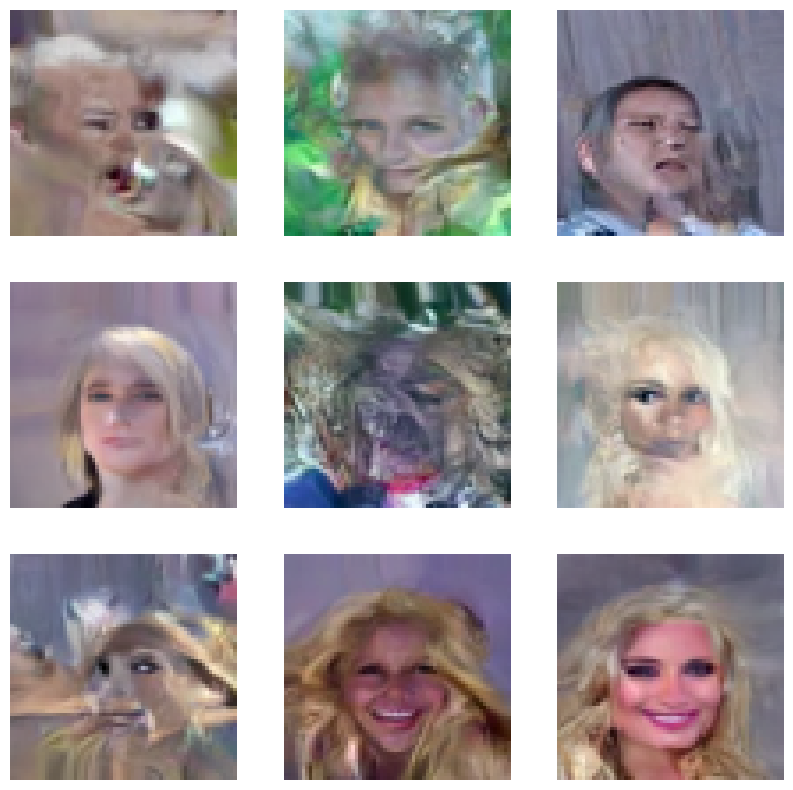

In [15]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()

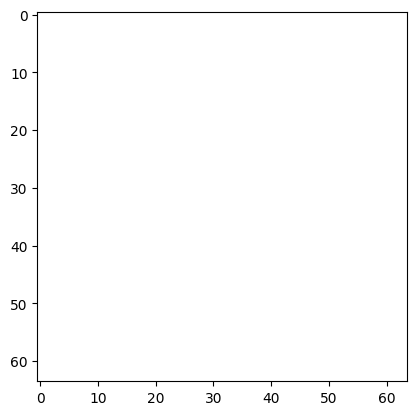

In [16]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion_relu.gif')
plt.show()